# VAR India

Vector auto-regressive models - VAR, VMA, VARIMA on Covid-19 Cases. For all models, the first-differenced dataset is used (I = 1).

## [Setup](#setup)
1. [Imports](#imports)
2. [Results table](#results_init)
3. [Ingestion](#ingestion)
4. [Plotting](#plotting_init)
5. [Statistical tests](#stattests1)
    1. [Johansen co-integration test](#jci_init)
    2. [Augmented DF Test](#adf_init)
6. [Differencing](#diff_init)
7. [Train test split](#traintest_init)

## Long-Term Forecasting

### [VAR Model](#var_model)
1. [Find order p of VAR](#var_p)
2. [VAR(1) Model](#var1)
3. [Plots of first differenced predictions](#diff_plot_var)
4. [Undifferencing and plotting](#undiff_var)
5. [Store metrics - MAE, MAPE, MSE](#store_var)
6. [Plot Train, Test, Forecast](#plot_final_var)

    
### [VMA Model](#vma_model)
1. [Find order q of VMA](#vma_q)
2. [VMA(1) Model](#vma1)
3. [Plots of first differenced predictions](#diff_plot_vma)
4. [Undifferencing and plotting](#undiff_vma)
5. [Store metrics - MAE, MAPE, MSE](#store_vma)
6. [Plot Train, Test, Forecast](#plot_final_vma)


### [VARMA Model](#varma_model)
1. [Find order (p, q) of VARMA](#varma_pq)
2. [VARMA(1, 1) Model](#varma11)
3. [Plots of first differenced predictions](#diff_plot_varma)
4. [Undifferencing and plotting](#undiff_varma)
5. [Store metrics - MAE, MAPE, MSE](#store_varma)
6. [Plot Train, Test, Forecast](#plot_final_varma)

## [Short-Term/Rolling Forecasting](#shortterm)

1. [VAR(1)](#var_roll)
2. [VMA(1)](#vma_roll)
3. [VARMA(1,1)](#varma_roll)

## [Final Metrics](#final_results)

<a name=setup></a>

# Setup

<a name=imports></a>
## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

import preprocessing
import plotting
import stats_testing
import metrics

warnings.filterwarnings("ignore")

<a name=results_init></a>
## Results table

In [2]:
results_columns = ['model', 'mse', 'mape', 'mae']
results_table = pd.DataFrame(columns=results_columns)

<a name=ingestion></a>

## Ingestion

In [3]:
daily_cases_india = pd.read_csv('../../cleaned_datasets/india/daily_cases_india.csv', parse_dates=['Date'])
# daily_vacc_india = pd.read_csv('../../cleaned_datasets/india/daily_vacc_india.csv', parse_dates=['date'])
cum_vacc_india = pd.read_csv('../../cleaned_datasets/india/cum_vacc_india.csv', parse_dates=['date'])
population = pd.read_csv('../../cleaned_datasets/world_population.csv', index_col='iso_code')

In [4]:
daily_cases_india.dtypes

Date         datetime64[ns]
Confirmed           float64
Deaths              float64
Recovered           float64
dtype: object

In [5]:
daily_cases_india

,Date,Confirmed,Deaths,Recovered
0,2020-01-30,NaN,NaN,NaN
1,2020-01-31,0.0,0.0,0.0
2,2020-02-01,0.0,0.0,0.0
3,2020-02-02,1.0,0.0,0.0
4,2020-02-03,1.0,0.0,0.0
...,...,...,...,...
707,2022-01-06,117100.0,302.0,0.0
708,2022-01-07,141986.0,285.0,0.0
709,2022-01-08,159632.0,327.0,0.0
710,2022-01-09,179723.0,146.0,0.0


In [6]:
cum_vacc_india.dtypes

date           datetime64[ns]
Total_Doses           float64
dtype: object

In [7]:
# cum_vacc_india.fillna(method='ffill')

In [8]:
first_vacc = cum_vacc_india.iloc[0].date
last_vacc = cum_vacc_india.iloc[-1].date

vacc_dates = pd.date_range(start=first_vacc, end=last_vacc)

In [9]:
cases_vacc = daily_cases_india.merge(cum_vacc_india, how='outer', left_on='Date', right_on='date')
cases_vacc = cases_vacc[["Date", "Confirmed", "Total_Doses"]]
cases_vacc

,Date,Confirmed,Total_Doses
0,2020-01-30,NaN,NaN
1,2020-01-31,0.0,NaN
2,2020-02-01,0.0,NaN
3,2020-02-02,1.0,NaN
4,2020-02-03,1.0,NaN
...,...,...,...
707,2022-01-06,117100.0,1.491991e+09
708,2022-01-07,141986.0,1.505592e+09
709,2022-01-08,159632.0,1.508007e+09
710,2022-01-09,179723.0,1.517705e+09


In [10]:
indexed = cases_vacc.set_index('Date')
preprocessing.fill_date_gaps(indexed, method='ffill', dates_range=vacc_dates)
indexed

,Confirmed,Total_Doses
Date,,
2020-01-30,0.0,0.000000e+00
2020-01-31,0.0,0.000000e+00
2020-02-01,0.0,0.000000e+00
2020-02-02,1.0,0.000000e+00
2020-02-03,1.0,0.000000e+00
...,...,...
2022-01-06,117100.0,1.491991e+09
2022-01-07,141986.0,1.505592e+09
2022-01-08,159632.0,1.508007e+09


<a name=plotting_init></a>
## Plot initial data

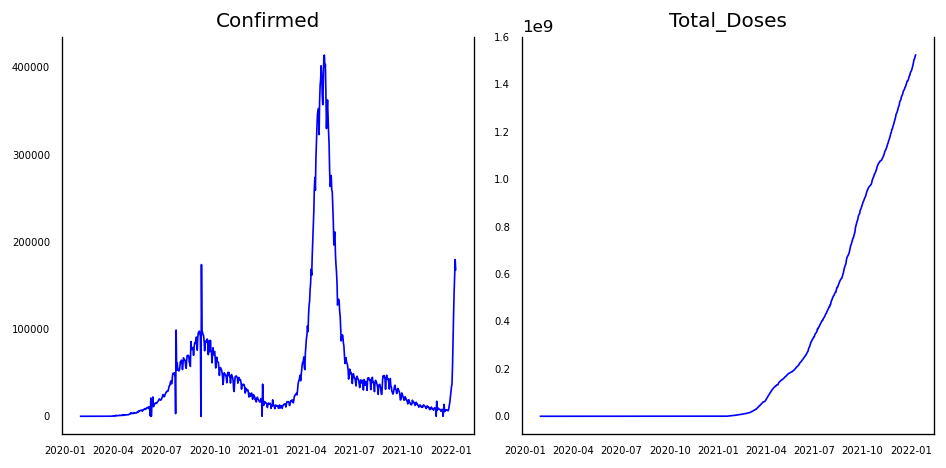

In [11]:
plotting.plot_side_by_side(train=indexed)

<a name=stattests1></a>
## Statistical tests

<a name=jci_init></a>

### Johansen co-integration test

In [12]:
stats_testing.cointegration_test(indexed)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  24.18     > 12.3212   =>   True
Total_Doses ::  2.31      > 4.1296    =>   False


From JCT, the two time series are not correlated.

<a name=adf_init></a>

### Augmented DF Test

In [13]:
# ADF Test on each column
for name, column in indexed.iteritems():
    stats_testing.run_dicky_fuller(column)
    print('\n')

Observations of Dickey-fuller test
Test Statistic                  -3.015566
p-value                          0.033466
#lags used                      15.000000
number of observations used    696.000000
critical value (1%)             -3.439780
critical value (5%)             -2.865702
critical value (10%)            -2.568986
dtype: float64


Observations of Dickey-fuller test
Test Statistic                   1.935822
p-value                          0.998584
#lags used                      12.000000
number of observations used    699.000000
critical value (1%)             -3.439740
critical value (5%)             -2.865684
critical value (10%)            -2.568977
dtype: float64




The TS is not stationary

<a name=diff_init></a>
## Differencing

## First order differencing

In [14]:
df_diff_1 = indexed.diff().dropna()
# df_diff_1

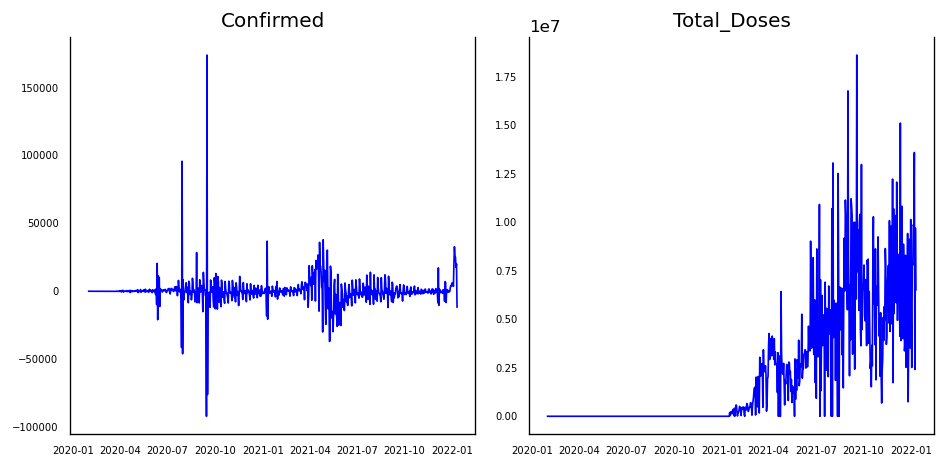

In [15]:
plotting.plot_side_by_side(train=df_diff_1)


In [16]:
stats_testing.cointegration_test(df_diff_1)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  68.38     > 12.3212   =>   True
Total_Doses ::  1.39      > 4.1296    =>   False


In [17]:
# ADF Test on each column
for name, column in df_diff_1.iteritems():
    stats_testing.run_dicky_fuller(column)
    print('\n')

Observations of Dickey-fuller test
Test Statistic                  -3.591903
p-value                          0.005918
#lags used                      19.000000
number of observations used    691.000000
critical value (1%)             -3.439849
critical value (5%)             -2.865732
critical value (10%)            -2.569002
dtype: float64


Observations of Dickey-fuller test
Test Statistic                  -0.548060
p-value                          0.882292
#lags used                      11.000000
number of observations used    699.000000
critical value (1%)             -3.439740
critical value (5%)             -2.865684
critical value (10%)            -2.568977
dtype: float64




From JCT, the two time series are not correlated.

## Second order differencing

In [18]:
df_diff_2 = df_diff_1.diff().dropna()
df_diff_2

,Confirmed,Total_Doses
Date,,
2020-02-01,0.0,0.0
2020-02-02,1.0,0.0
2020-02-03,-1.0,0.0
2020-02-04,-1.0,0.0
2020-02-05,1.0,0.0
...,...,...
2022-01-06,-6659.0,-86635.0
2022-01-07,-1286.0,3813830.0
2022-01-08,-7240.0,-11185385.0


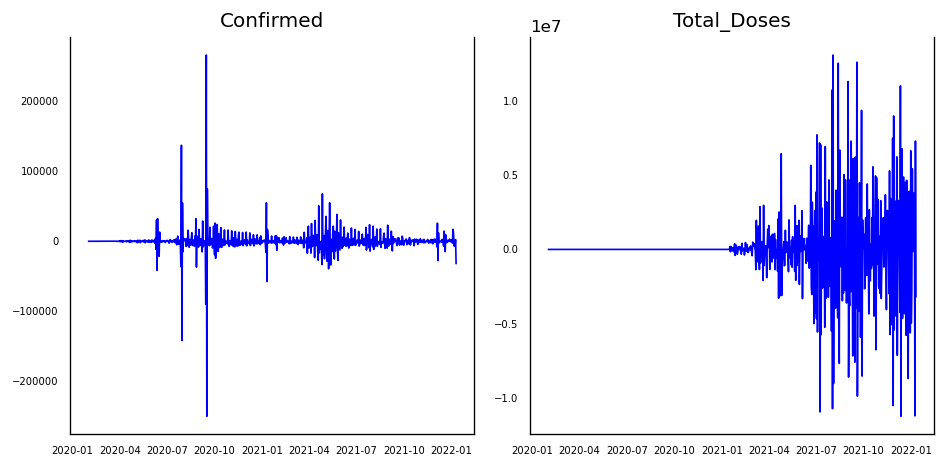

In [19]:
plotting.plot_side_by_side(train=df_diff_2)

In [20]:
# Cointegration test

stats_testing.cointegration_test(df_diff_2)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  820.14    > 12.3212   =>   True
Total_Doses ::  295.55    > 4.1296    =>   True


From JCT, the two time series are correlated.

In [21]:
# ADF Test on each column
for name, column in df_diff_2.iteritems():
    stats_testing.run_dicky_fuller(column)
    print('\n')

Observations of Dickey-fuller test
Test Statistic                -7.025341e+00
p-value                        6.385996e-10
#lags used                     1.300000e+01
number of observations used    6.960000e+02
critical value (1%)           -3.439780e+00
critical value (5%)           -2.865702e+00
critical value (10%)          -2.568986e+00
dtype: float64


Observations of Dickey-fuller test
Test Statistic                -1.312820e+01
p-value                        1.513692e-24
#lags used                     1.000000e+01
number of observations used    6.990000e+02
critical value (1%)           -3.439740e+00
critical value (5%)           -2.865684e+00
critical value (10%)          -2.568977e+00
dtype: float64




From ADF, both are stationary.

<a name=traintest_init></a>
## Train-test split

### Train-test split

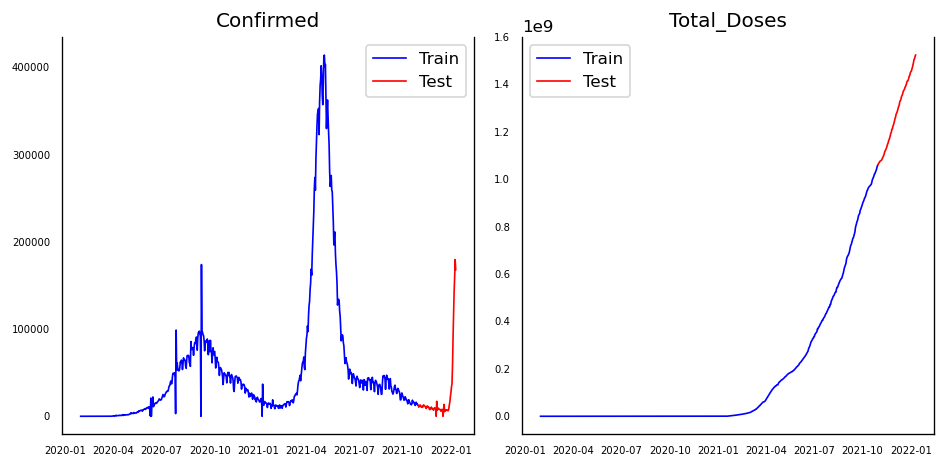

In [22]:
train, test = preprocessing.train_test_split(indexed, fraction=0.9)

plotting.plot_side_by_side(train=train, test=test)

<a name=var_model></a>

# VAR Model

<a name=var_p></a>
## Finding the order p for VAR(p)

Using PACF plot

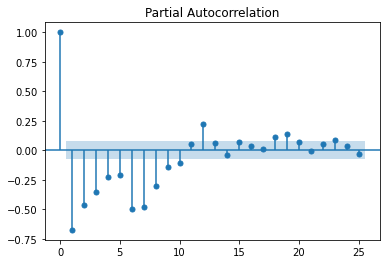

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf_var_confirmed = plot_pacf(train['Confirmed'].diff().dropna().diff().dropna(), lags=25)

In [24]:
metrics.evaluate_varma_models(train, test, [5, 8, 9, 10], [0], column='Confirmed')

VARMA(5, 0): MSE=7301440143.014, MAPE=856.353, MAE=83843.413
VARMA(8, 0): MSE=101625477760.473, MAPE=3132.937, MAE=309331.964
VARMA(9, 0): MSE=48595666734.458, MAPE=2061.979, MAE=206205.960
VARMA(10, 0): MSE=42829951875.646, MAPE=1930.084, MAE=193695.374

Best VARMA(5, 0): MSE=7301440143.014


<a name=var1></a>
## VAR(5) Model

In [25]:
from statsmodels.tsa.statespace.varmax import VARMAX

model = VARMAX(train, order=(5, 0))
model_fit = model.fit()
forecasted = model_fit.get_prediction(start=len(train), end=len(train)+len(test)-1).predicted_mean

df_forecast = pd.DataFrame(forecasted, index=test.index)
df_forecast.rename(columns = {'Confirmed': 'Confirmed_forecast', 'Total_Doses': 'Total_Doses_forecast'}, inplace=True)

forecasted_conf = df_forecast.join(test)[['Confirmed', 'Confirmed_forecast']]
forecasted_vacc = df_forecast.join(test)[['Total_Doses', 'Total_Doses_forecast']]

# conf = model_fit.conf_int(alpha=0.05)
# forecasted.predicted_mean

In [26]:
model_fit.summary()

Dep. Variable:,"['Confirmed', 'Total_Doses']",No. Observations:,640
Model:,VAR(5),Log Likelihood,-1734633.033
,+ intercept,AIC,3469316.066
Date:,"Thu, 27 Jan 2022",BIC,3469427.603
Time:,14:52:58,HQIC,3469359.359
Sample:,01-30-2020,,
,- 10-30-2021,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"521.38, 634.73",Jarque-Bera (JB):,"354.95, 196.78"
Prob(Q):,"0.00, 0.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"2.38, 0.18",Skew:,"-0.45, 1.26"


In [62]:
# # preprocessing.get_all_attrs(model_fit)

# for attr in dir(model_fit.model):
#     if not attr.startswith('_'):
#         print(attr)

# model_fit.model.k_ar

<a name=diff_plot_var></a>

## Plots of Predictions (Differenced)

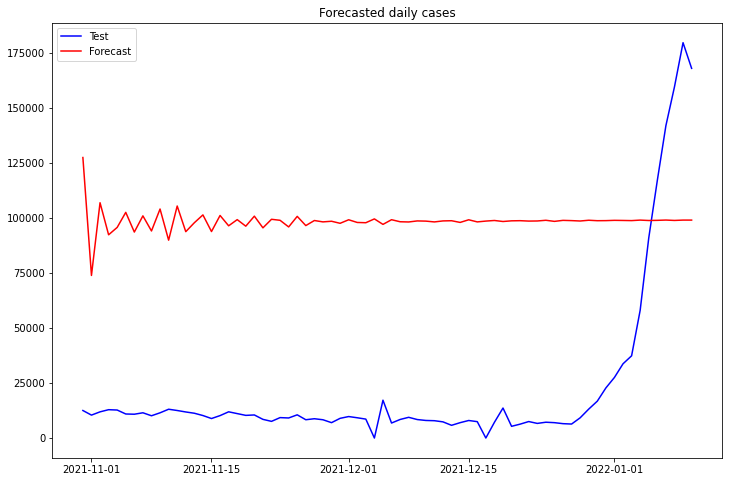

In [63]:
plotting.plot_fore_test(test=test[['Confirmed']], fore=forecasted[['Confirmed']], title='Forecasted daily cases')

In [328]:
# plot_fore_test(test[['Total_Doses']], forecasted[['Total_Doses']], title='Diffed Daily vaccinations')

<a name=store_var></a>

## Store metrics

In [67]:
results_table = results_table.append({
    'model': preprocessing.get_varma_model_name(model_fit),
    'mse': metrics.mean_squared_error(test['Confirmed'], forecasted['Confirmed']),
    'mape': metrics.MAPE(test['Confirmed'], forecasted['Confirmed']),
    'mae': metrics.mean_absolute_error(test['Confirmed'], forecasted['Confirmed'])
}, ignore_index=True)

results_table

AttributeError: module 'preprocessing' has no attribute 'get_varma_model_name'

<a name=plot_final_var></a>

## Plot Train, Test, Forecast

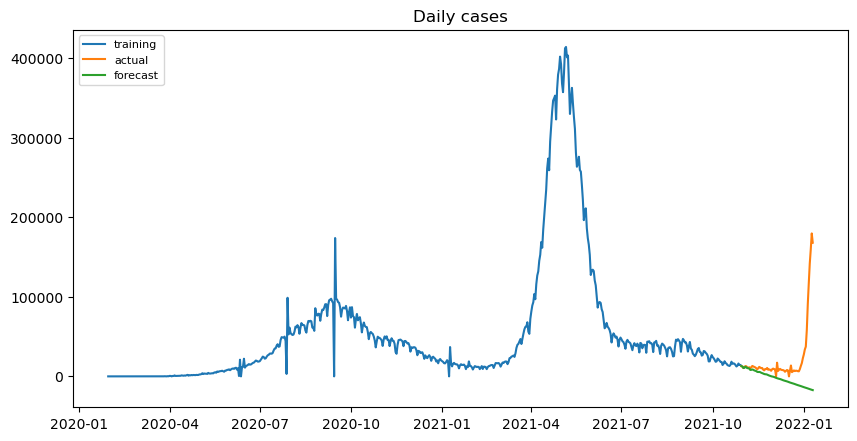

In [336]:
# Plot of daily cases
plotting.plot_train_test_fore(train=train.Confirmed, test=test[['Confirmed']], fore=forecasted[['Confirmed']], title='Daily cases')


Clearly, a VAR model is not good enough to make predictions

In [337]:
# Plot of daily doses
#plot_train_test_fore(train_original.Total_Doses, test_original[['undiff_Total_Doses']], fore_original[['undiff_Total_Doses']], title='Daily doses', figpath='../../figures/v_ar/india_vacc.eps')


<a name=vma_model></a>

# VMA Model

<a name=vma_q></a>
## Find order q of VMA

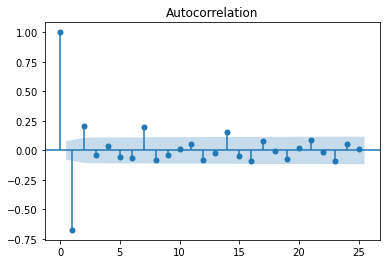

In [338]:
acf_varma_confirmed = plot_acf(train['Confirmed'], lags=25)

In [339]:
evaluate_models(train, test, [0], [1, 2, 7], column='Confirmed')

/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


VARMA(0, 1) MSE=55075424.840, MAPE=99.612, MAE=3849.341


/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


VARMA(0, 2) MSE=55159775.455, MAPE=100.432, MAE=3867.033


/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


VARMA(0, 7) MSE=55136232.421, MAPE=104.755, MAE=3883.938

Best VARMA(0, 1) MSE=55075424.840


<a name=vma1></a>

## VMA(2)

In [340]:
model_ma = VARMAX(train, order=(0,2))
model_fit_ma = model_ma.fit()
forecasted_ma = model_fit_ma.forecast(len(test))

df_forecast_ma = pd.DataFrame(forecasted_ma, index=test.index)
df_forecast_ma.rename(columns = {'Confirmed': 'Confirmed_forecast', 'Total_Doses': 'Total_Doses_forecast'}, inplace=True)

forecasted_conf_ma = df_forecast_ma.join(test)[['Confirmed', 'Confirmed_forecast']]
forecasted_vacc_ma = df_forecast_ma.join(test)[['Total_Doses', 'Total_Doses_forecast']]

# conf = model_fit.conf_int(alpha=0.05)

/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [341]:
model_fit_ma.summary()

Dep. Variable:,"['Confirmed', 'Total_Doses']",No. Observations:,639
Model:,VMA(2),Log Likelihood,-3867.882
,+ intercept,AIC,7761.763
Date:,"Thu, 27 Jan 2022",BIC,7819.742
Time:,12:34:47,HQIC,7784.269
Sample:,02-01-2020,,
,- 10-31-2021,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"345.93, 280.83",Jarque-Bera (JB):,"180323.96, 4070.69"
Prob(Q):,"0.00, 0.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"0.61, 13224.03",Skew:,"1.49, 0.91"


<a name=diff_plot_vma></a>

## Plots of Predictions (Differenced)

In [342]:
# plot_fore_test(test[['Confirmed']], forecasted_ma[['Confirmed']], title='Diffed Daily cases')

In [343]:
# plot_fore_test(test[['Total_Doses']], forecasted_ma[['Total_Doses']], title='Diffed Daily vaccinations')

<a name=undiff_vma></a>

## Undifferencing and plotting

In [344]:
renamed_df_ma = df_forecast_ma.rename(columns={'Confirmed_forecast': 'Confirmed', 'Total_Doses_forecast': 'Total_Doses'}, inplace=False)

start_index_1_ma = df_diff_1.index.get_loc(renamed_df_ma.index[0])-1
fore_original_1_ma = invert_transformation(renamed_df_ma, df_diff_1.iloc[start_index_1:])

fore_original_1_ma.rename(columns={'undiff_Confirmed': 'Confirmed', 'undiff_Total_Doses': 'Total_Doses'}, inplace=True)

start_index_ma = indexed.index.get_loc(fore_original_1_ma.index[0])-1
fore_original_ma = invert_transformation(fore_original_1_ma, indexed.iloc[start_index:])

In [345]:
fore_original_ma

,undiff_Confirmed,undiff_Total_Doses
Date,,
2021-10-30,12830.000000,0.759640
2021-10-31,12514.000000,0.762613
2021-11-01,12445.212293,0.766280
2021-11-02,11932.806553,0.770455
2021-11-03,11419.906291,0.774633
...,...,...
2022-01-06,-22434.317706,1.047032
2022-01-07,-22979.361943,1.051366
2022-01-08,-23524.900704,1.055703


<a name=store_vma></a>

## Store metrics

In [346]:
results_table = results_table.append({
    'model': 'VMA(2)',
    'mse': mean_squared_error(test_original['undiff_Confirmed'], fore_original_ma['undiff_Confirmed']),
    'mape': MAPE(test_original['undiff_Confirmed'], fore_original_ma['undiff_Confirmed']),
    'mae': mean_absolute_error(test_original['undiff_Confirmed'], fore_original_ma['undiff_Confirmed'])
}, ignore_index=True)

results_table

,model,mse,mape,mae
0,VAR(7),2.514099e+09,117.435890,2.495212e+04
1,VMA(2),2.993976e+09,169.108655,3.061098e+04
2,VMA(2),4.632213e+09,290.333303,4.414489e+04
3,VMA(2),5.183840e+11,5683.657941,6.194542e+05
4,VMA(2),2.507027e+12,11920.329149,1.338023e+06
5,VMA(2),6.403827e+09,399.122091,5.612783e+04
6,VMA(2),2.993976e+09,169.108655,3.061098e+04
7,VAR(7),2.507726e+09,116.761621,2.487682e+04
8,VMA(2),2.993976e+09,169.108655,3.061098e+04
9,VAR(7),2.507726e+09,116.761621,2.487682e+04


In [347]:
# end_index = indexed.index.get_loc(fore_original_ma.index[0])
# train_original_ma = indexed[:end_index]
# plot_2col_subplots([train_original, fore_original_ma])

<a name=plot_final_vma></a>

## Plot Train, Test, Forecast

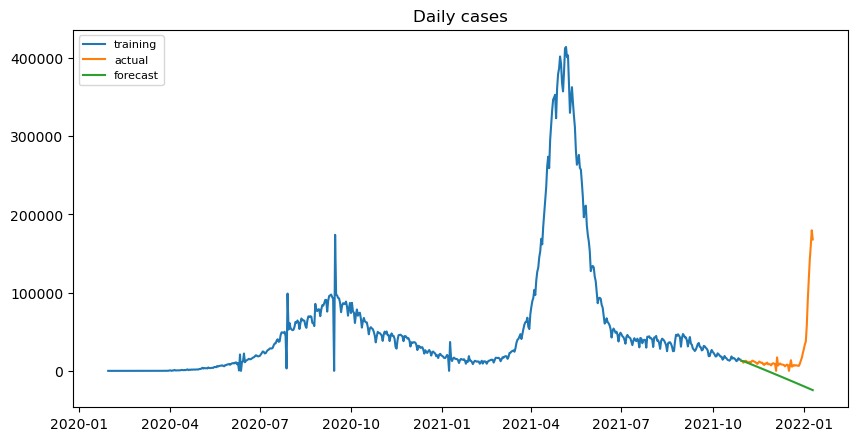

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [348]:
plot_train_test_fore(train_original.Confirmed, test_original[['undiff_Confirmed']], fore_original_ma[['undiff_Confirmed']], title='Daily cases', figpath='../../figures/v_ar/india_cases.eps')


<a name=varma_model></a>

# VARMA

<a name=varma_pq></a>

## Find order (p, q) of VARMA

PACF/ACF

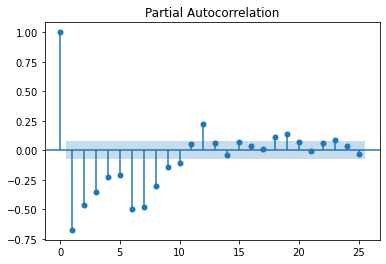

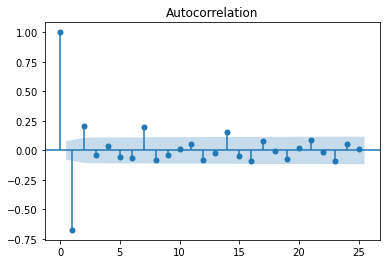

In [349]:
pacf_varma_confirmed = plot_pacf(train['Confirmed'], lags=25)
acf_varma_confirmed = plot_acf(train['Confirmed'], lags=25)

VARIMA(8, 2)

In [246]:
evaluate_models(train, test, [8, 9, 10], [2], column='Confirmed')

/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


VARMA(8, 2) MSE=54553003.473, MAPE=166.778, MAE=3724.967


/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


VARMA(9, 2) MSE=54669382.785, MAPE=153.476, MAE=3761.947


/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


VARMA(10, 2) MSE=54681298.137, MAPE=183.289, MAE=3777.573

Best VARMA(8, 2) MSE=54553003.473


<a name=varma11></a>

## VARMA(8, 2)

In [247]:
model = VARMAX(train, order=(8,2))
model_fit = model.fit()
yhat = model_fit.forecast(len(test))
#yhat

/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<a name=diff_plot_varma></a>

## Plots of Predictions (Differenced)

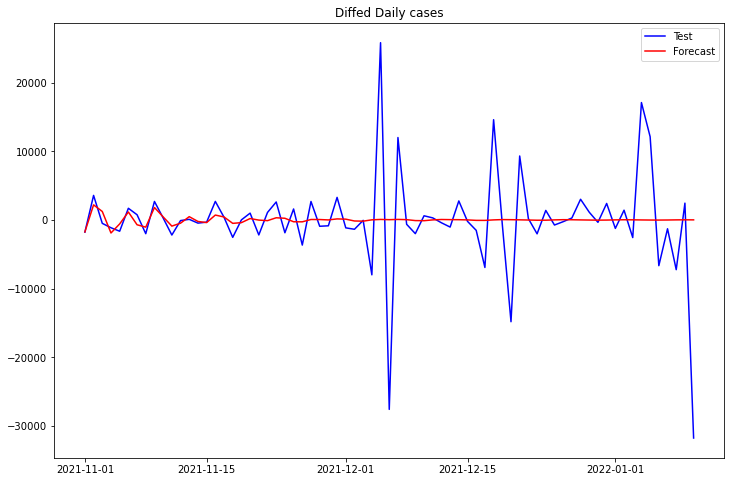

In [248]:
plot_fore_test(test[['Confirmed']], yhat[['Confirmed']], title='Diffed Daily cases')

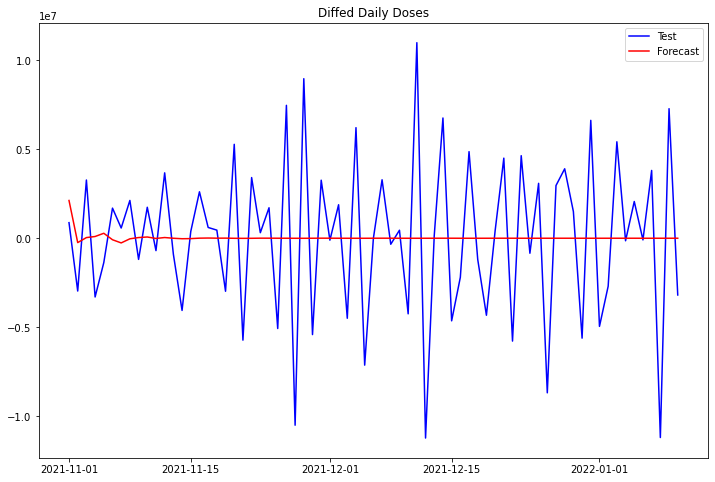

In [249]:
plot_fore_test(test[['Total_Doses']], yhat[['Total_Doses']], title='Diffed Daily Doses')

<a name=undiff_varma></a>

## Undifferencing and plotting

In [274]:
# Un-diff the test dataset

fore_original_1_varma = invert_transformation(yhat, df_diff_1.iloc[start_index_1:])
fore_original_1_varma

fore_original_1_varma.rename(columns={'undiff_Confirmed': 'Confirmed', 'undiff_Total_Doses': 'Total_Doses'}, inplace=True)

start_index_varma = indexed.index.get_loc(fore_original_1_varma.index[0])-1
fore_original_varma = invert_transformation(fore_original_1_varma, indexed.iloc[start_index_varma:])

fore_original_varma

,undiff_Confirmed,undiff_Total_Doses
Date,,
2021-10-30,12830.000000,1.058489e+09
2021-10-31,12514.000000,1.062631e+09
2021-11-01,10456.437431,1.068900e+09
2021-11-02,10593.469148,1.074930e+09
2021-11-03,11961.730638,1.081003e+09
...,...,...
2022-01-06,-16683.438858,1.489833e+09
2022-01-07,-17155.897497,1.496427e+09
2022-01-08,-17619.873763,1.503027e+09


In [275]:
#plot_fore_test(test_original[['undiff_Confirmed']], fore_original_3[['undiff_Confirmed']], title='Daily cases')

In [276]:
#plot_fore_test(test_original[['undiff_Total_Doses']], fore_original_3[['undiff_Total_Doses']], title='Daily Doses')

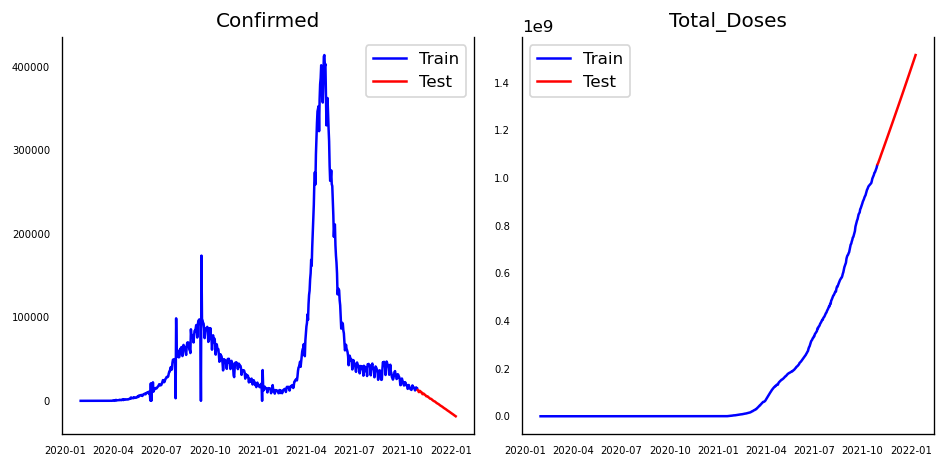

In [277]:
plot_2col_subplots([train_original, fore_original_varma])

<a name=store_varma></a>

## Store metrics

In [278]:
results_table = results_table.append({
    'model': 'VARMA(1,1)',
    'mse': mean_squared_error(test_original['undiff_Confirmed'], fore_original_varma['undiff_Confirmed']),
    'mape': MAPE(test_original['undiff_Confirmed'], fore_original_varma['undiff_Confirmed']),
    'mae': mean_absolute_error(test_original['undiff_Confirmed'], fore_original_varma['undiff_Confirmed'])
}, ignore_index=True)

results_table

,model,mse,mape,mae
0,VAR(7),2.514099e+09,117.435890,2.495212e+04
1,VMA(2),2.993976e+09,169.108655,3.061098e+04
2,VMA(2),4.632213e+09,290.333303,4.414489e+04
3,VMA(2),5.183840e+11,5683.657941,6.194542e+05
4,VMA(2),2.507027e+12,11920.329149,1.338023e+06
5,VMA(2),6.403827e+09,399.122091,5.612783e+04
6,VMA(2),2.993976e+09,169.108655,3.061098e+04
7,VAR(7),2.507726e+09,116.761621,2.487682e+04
8,VMA(2),2.993976e+09,169.108655,3.061098e+04
9,VAR(7),2.507726e+09,116.761621,2.487682e+04


<a name=plot_final_varma></a>

## Plot Train, Test, Forecast

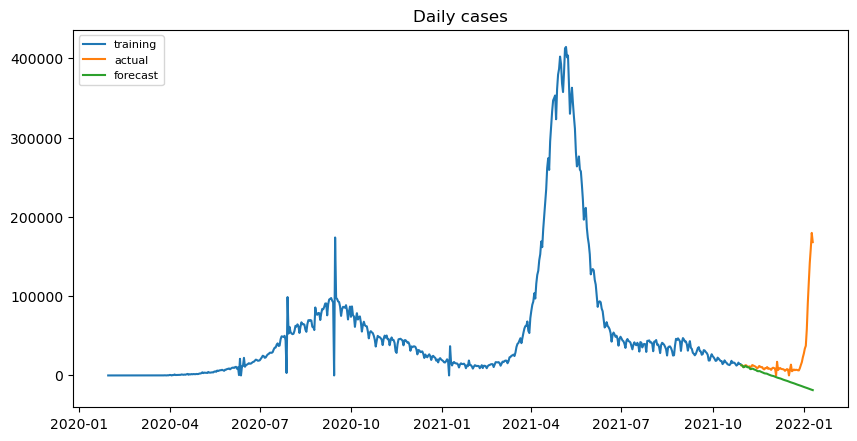

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [279]:
# Plot of daily cases
plot_train_test_fore(train_original.Confirmed, test_original[['undiff_Confirmed']], fore_original_varma[['undiff_Confirmed']], title='Daily cases', figpath='../../figures/varma/india_cases.eps')


In [280]:
# Plot of daily doses
# plot_train_test_fore(train_original.Total_Doses, test_original[['undiff_Total_Doses']], fore_original_3[['undiff_Total_Doses']], title='Daily cases', figpath='../../figures/varma/india_vacc.eps')

<a name=shortterm></a>

# Rolling forecasts

In [281]:
history = train.copy()
predicted = pd.DataFrame(columns=[
    'VAR_Confirmed', 
    'VAR_Total_Doses', 
    'VMA_Confirmed', 
    'VMA_Total_Doses', 
    'VARMA_Confirmed', 
    'VARMA_Total_Doses'
], index=test.index)


# predicted

for t in range(len(test)):
    # 3 models
    var = VARMAX(history, order=(8,0))
    vma = VARMAX(history, order=(0,2))
    varma = VARMAX(history, order=(8,2))
    
    # 3 fitted models
    var_fit = var.fit()
    vma_fit = vma.fit()
    varma_fit = varma.fit()
    
    # Predictions
    yhat_var = var_fit.forecast()
    yhat_vma = vma_fit.forecast()
    yhat_varma = varma_fit.forecast()
    
    # Next index to insert
    # newindex = history.index[-1] + pd.to_timedelta(1, 'D')
    
    # Confirmed cases
    predicted.iloc[t]['VAR_Confirmed'] = yhat_var['Confirmed'].values[0]
    predicted.iloc[t]['VMA_Confirmed'] = yhat_vma['Confirmed'].values[0]
    predicted.iloc[t]['VARMA_Confirmed'] = yhat_varma['Confirmed'].values[0]
    
    # Total doses
    predicted.iloc[t]['VAR_Total_Doses'] = yhat_var['Total_Doses'].values[0]
    predicted.iloc[t]['VMA_Total_Doses'] = yhat_vma['Total_Doses'].values[0]
    predicted.iloc[t]['VARMA_Total_Doses'] = yhat_varma['Total_Doses'].values[0]
    
    history = history.append(test.iloc[t])
    # history[newindex]['Total_Doses'] = test.iloc[t]['Total_Doses']
    
    # print('predicted =', yhat.values, ' ; actual =', test.iloc[t].values)

/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/vibhamasti/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimi

In [284]:
predicted

,VAR_Confirmed,VAR_Total_Doses,VMA_Confirmed,VMA_Total_Doses,VARMA_Confirmed,VARMA_Total_Doses
Date,,,,,,
2021-11-01,-1743.805232,2144016.200689,-1491.198562,1968685.833527,-1741.562569,2126541.770098
2021-11-02,1869.042583,1021362.118847,1814.327778,947594.559986,1904.946489,1025331.954342
2021-11-03,-2005.577962,3829466.388349,-1483.57683,3283457.605413,-1991.787604,3873737.543745
2021-11-04,-1374.077258,-216740.547906,-794.592687,-14566.463404,-1556.922827,-226418.060738
2021-11-05,-1038.085392,3530144.027961,-1655.442057,2813656.264103,-1059.866561,3570169.385854
...,...,...,...,...,...,...
2022-01-06,-49288.785524,-3254376.956199,-25826.029177,-2291281.470057,-49412.580324,-3188136.49769
2022-01-07,-38763.059686,-1609901.217796,-17389.989639,-1375180.610137,-38630.67647,-1507345.45904
2022-01-08,-30177.272067,-5514218.573399,-18009.393931,-3734683.264314,-29860.042073,-5433311.857009


<a name=var_roll></a>

## VAR(8)

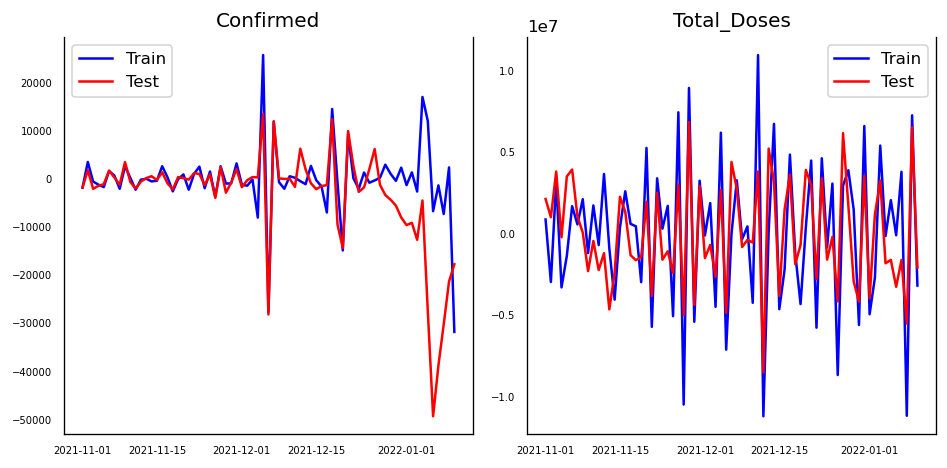

In [285]:
plot_2col_subplots([test, predicted[['VAR_Confirmed', 'VAR_Total_Doses']]])

In [287]:
# Un-diffing

pred_var = predicted[['VAR_Confirmed', 'VAR_Total_Doses']].rename(columns={'VAR_Confirmed': 'Confirmed', 'VAR_Total_Doses': 'Total_Doses'}, inplace=False)


fore_original_var_roll_1 = invert_transformation(pred_var, df_diff_1.iloc[start_index_1:])
fore_original_var_roll_1.rename(columns={'undiff_Confirmed': 'Confirmed', 'undiff_Total_Doses': 'Total_Doses'}, inplace=True)

# Un-diff the test dataset

# fore_original_1_varma = invert_transformation(yhat, df_diff_1.iloc[start_index_1:])
# fore_original_1_varma

# fore_original_1_varma.rename(columns={'undiff_Confirmed': 'Confirmed', 'undiff_Total_Doses': 'Total_Doses'}, inplace=True)

start_index_var_roll = indexed.index.get_loc(fore_original_var_roll_1.index[0])-1
fore_original_var_roll = invert_transformation(fore_original_var_roll_1, indexed.iloc[start_index_var_roll:])

fore_original_var_roll

,undiff_Confirmed,undiff_Total_Doses
Date,,
2021-10-30,12830.0,1058489433.0
2021-10-31,12514.0,1062631351.0
2021-11-01,10454.194768,1068917285.200689
2021-11-02,10263.432119,1076224581.520225
2021-11-03,8067.091508,1087361344.22811
...,...,...
2022-01-06,-673108.008834,1591054418.351365
2022-01-07,-846978.035399,1595052351.911504
2022-01-08,-1051025.334031,1593536066.898243


In [132]:
# fore_original_4_var

In [288]:
results_table = results_table.append({
    'model': 'VAR(8) - rolling',
    'mse': mean_squared_error(test_original['undiff_Confirmed'], fore_original_var_roll['undiff_Confirmed']),
    'mape': MAPE(test_original['undiff_Confirmed'], fore_original_var_roll['undiff_Confirmed']),
    'mae': mean_absolute_error(test_original['undiff_Confirmed'], fore_original_var_roll['undiff_Confirmed'])
}, ignore_index=True)

results_table

,model,mse,mape,mae
0,VAR(7),2.514099e+09,117.435890,2.495212e+04
1,VMA(2),2.993976e+09,169.108655,3.061098e+04
2,VMA(2),4.632213e+09,290.333303,4.414489e+04
3,VMA(2),5.183840e+11,5683.657941,6.194542e+05
4,VMA(2),2.507027e+12,11920.329149,1.338023e+06
5,VMA(2),6.403827e+09,399.122091,5.612783e+04
6,VMA(2),2.993976e+09,169.108655,3.061098e+04
7,VAR(7),2.507726e+09,116.761621,2.487682e+04
8,VMA(2),2.993976e+09,169.108655,3.061098e+04
9,VAR(7),2.507726e+09,116.761621,2.487682e+04


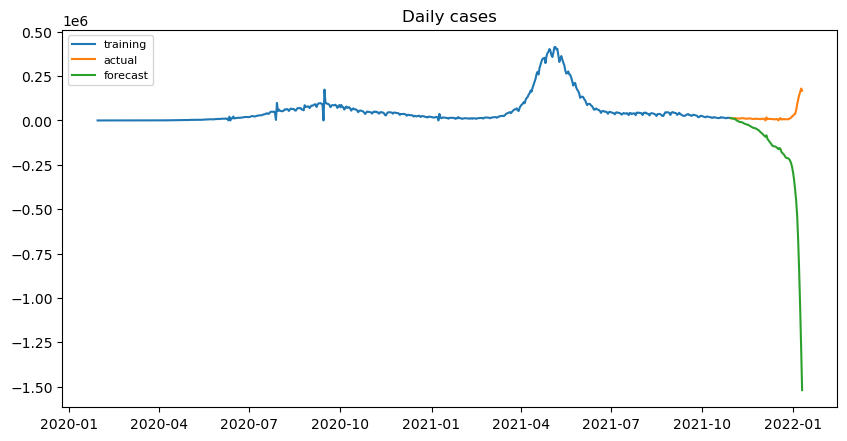

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [289]:
plot_train_test_fore(train_original.Confirmed, test_original[['undiff_Confirmed']], fore_original_var_roll[['undiff_Confirmed']], title='Daily cases', figpath='../../figures/varma/india_cases.eps')


<a name=vma_roll></a>

## VMA(1)

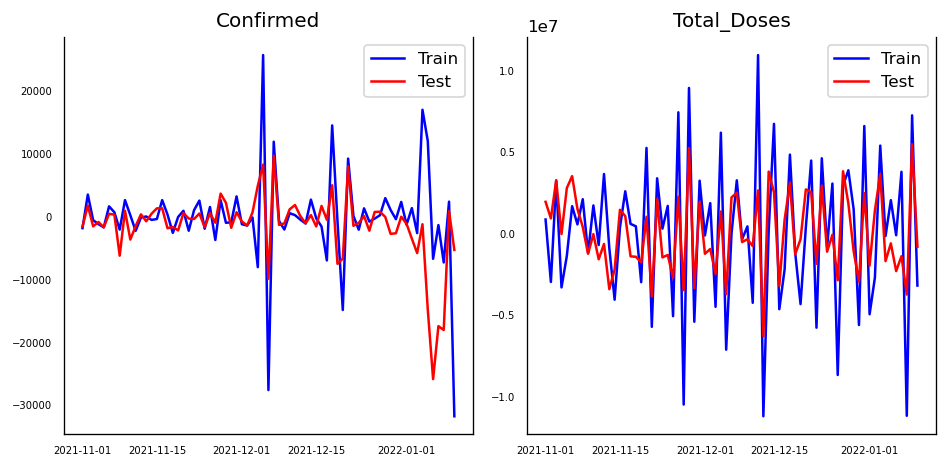

In [290]:
plot_2col_subplots([test, predicted[['VMA_Confirmed', 'VMA_Total_Doses']]])

In [291]:
# Un-diffing

# pred_vma = predicted[['VMA_Confirmed', 'VMA_Total_Doses']].rename(columns={'VMA_Confirmed': 'Confirmed', 'VMA_Total_Doses': 'Total_Doses'}, inplace=False)
# fore_original_4_vma = invert_transformation(pred_vma, indexed.iloc[start_index:])

pred_vma = predicted[['VMA_Confirmed', 'VMA_Total_Doses']].rename(columns={'VMA_Confirmed': 'Confirmed', 'VMA_Total_Doses': 'Total_Doses'}, inplace=False)


fore_original_vma_roll_1 = invert_transformation(pred_vma, df_diff_1.iloc[start_index_1:])
fore_original_vma_roll_1.rename(columns={'undiff_Confirmed': 'Confirmed', 'undiff_Total_Doses': 'Total_Doses'}, inplace=True)

# Un-diff the test dataset

# fore_original_1_varma = invert_transformation(yhat, df_diff_1.iloc[start_index_1:])
# fore_original_1_varma

# fore_original_1_varma.rename(columns={'undiff_Confirmed': 'Confirmed', 'undiff_Total_Doses': 'Total_Doses'}, inplace=True)

start_index_vma_roll = indexed.index.get_loc(fore_original_vma_roll_1.index[0])-1
fore_original_vma_roll = invert_transformation(fore_original_vma_roll_1, indexed.iloc[start_index_vma_roll:])

fore_original_vma_roll

,undiff_Confirmed,undiff_Total_Doses
Date,,
2021-10-30,12830.0,1058489433.0
2021-10-31,12514.0,1062631351.0
2021-11-01,10706.801438,1068741954.833527
2021-11-02,10713.930653,1075800153.227041
2021-11-03,9237.483038,1086141809.225967
...,...,...
2022-01-06,-585978.741695,1519988929.74202
2022-01-07,-664238.652668,1526297890.319024
2022-01-08,-760507.957572,1528872167.631716


In [139]:
# fore_original_4_vma

In [292]:
results_table = results_table.append({
    'model': 'VMA(1) - rolling',
    'mse': mean_squared_error(test_original['undiff_Confirmed'], fore_original_vma_roll['undiff_Confirmed']),
    'mape': MAPE(test_original['undiff_Confirmed'], fore_original_vma_roll['undiff_Confirmed']),
    'mae': mean_absolute_error(test_original['undiff_Confirmed'], fore_original_vma_roll['undiff_Confirmed'])
}, ignore_index=True)

results_table

,model,mse,mape,mae
0,VAR(7),2.514099e+09,117.435890,2.495212e+04
1,VMA(2),2.993976e+09,169.108655,3.061098e+04
2,VMA(2),4.632213e+09,290.333303,4.414489e+04
3,VMA(2),5.183840e+11,5683.657941,6.194542e+05
4,VMA(2),2.507027e+12,11920.329149,1.338023e+06
5,VMA(2),6.403827e+09,399.122091,5.612783e+04
6,VMA(2),2.993976e+09,169.108655,3.061098e+04
7,VAR(7),2.507726e+09,116.761621,2.487682e+04
8,VMA(2),2.993976e+09,169.108655,3.061098e+04
9,VAR(7),2.507726e+09,116.761621,2.487682e+04


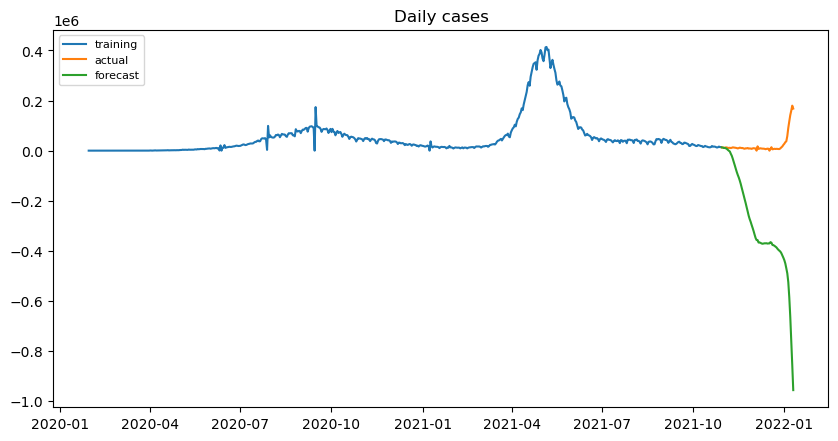

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [293]:
plot_train_test_fore(train_original.Confirmed, test_original[['undiff_Confirmed']], fore_original_vma_roll[['undiff_Confirmed']], title='Daily cases', figpath='../../figures/varma/india_cases_vma.eps')



<a name=varma_roll></a>

## VARMA(1,1)

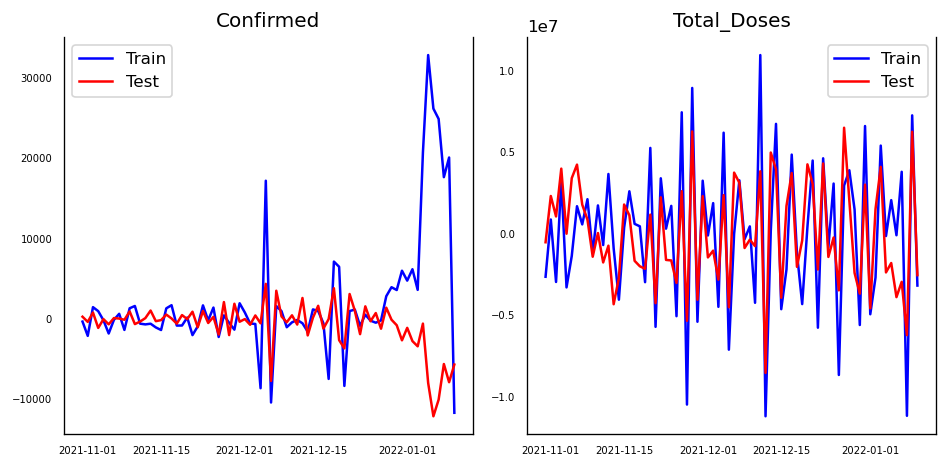

In [143]:
plot_2col_subplots([test, predicted[['VARMA_Confirmed', 'VARMA_Total_Doses']]])

In [144]:
# Un-diffing

pred_varma = predicted[['VARMA_Confirmed', 'VARMA_Total_Doses']].rename(columns={'VARMA_Confirmed': 'Confirmed', 'VARMA_Total_Doses': 'Total_Doses'}, inplace=False)
fore_original_4_varma = invert_transformation(pred_varma, indexed.iloc[start_index:])

In [145]:
# fore_original_4_varma

In [146]:
results_table = results_table.append({
    'model': 'VARMA(1, 1) - rolling',
    'mse': mean_squared_error(test_original['undiff_Confirmed'], fore_original_4_varma['undiff_Confirmed']),
    'mape': MAPE(test_original['undiff_Confirmed'], fore_original_4_varma['undiff_Confirmed']),
    'mae': mean_absolute_error(test_original['undiff_Confirmed'], fore_original_4_varma['undiff_Confirmed'])
}, ignore_index=True)

results_table

,model,mse,mape,mae
0,VAR(1),1.500046e+09,56.212082,15872.635062
1,VMA(1),1.492894e+09,60.004170,16149.503426
2,"VARMA(1,1)",1.496983e+09,56.464454,15871.593152
3,VAR(1) - rolling,2.575823e+09,70.259407,20380.566615
4,VMA(1) - rolling,2.759544e+09,81.473474,21840.098543
5,"VARMA(1, 1) - rolling",2.606280e+09,58.192571,19462.968069


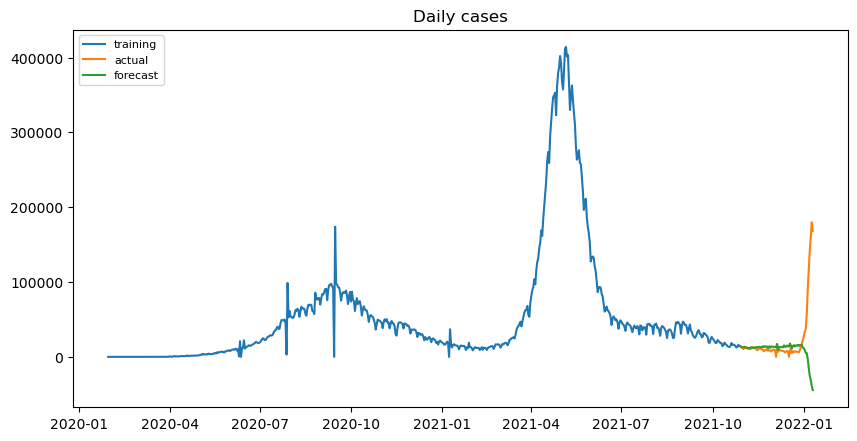

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [147]:
plot_train_test_fore(train_original.Confirmed, test_original[['undiff_Confirmed']], fore_original_4_varma[['undiff_Confirmed']], title='Daily cases', figpath='../../figures/varma/india_cases_varma.eps')


<a name=final_results></a>

# Final Results

In [148]:
results_table

,model,mse,mape,mae
0,VAR(1),1.500046e+09,56.212082,15872.635062
1,VMA(1),1.492894e+09,60.004170,16149.503426
2,"VARMA(1,1)",1.496983e+09,56.464454,15871.593152
3,VAR(1) - rolling,2.575823e+09,70.259407,20380.566615
4,VMA(1) - rolling,2.759544e+09,81.473474,21840.098543
5,"VARMA(1, 1) - rolling",2.606280e+09,58.192571,19462.968069
